In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib, statsmodels, scipy, random, glob, sklearn, csv, itertools, logomaker, Bio, warnings, textdistance
matplotlib.style.use('seaborn-muted')

from Bio import motifs

from matplotlib import *
from matplotlib import collections as mc
from scipy import stats
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.stats as smstats
import matplotlib.gridspec as gridspec
import statsmodels.formula.api as smf

from collections import Counter, defaultdict

base_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/Github_repo/'
figure_out_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/figures/'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

sns.set_style("whitegrid")

warnings.filterwarnings('ignore')
%matplotlib inline
def progress_bar(i, max_i):
    sys.stdout.write('\r')
    j = (i+1)/max_i
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()

Matplotlib is building the font cache; this may take a moment.


In [2]:
def unify_event_id(event_id):
    #143;SE:143:44-225:305-1004:+
    ref_id = var2ref[event_id.split(';')[0]]
    new_event_id = ref_id + ';SE:' + ref_id + ':' + ':'.join(event_id.split(':')[2:])
    return new_event_id

var2ref = {}
a = open(base_dir + 'preprocessed_data/ref2var.tsv', 'r')
reader = csv.reader(a, delimiter ='\t')
for line in reader:
    for var in line[1].split(','):
        var2ref[var] = line[0]
    var2ref[line[0]] = line[0]
a.close()


def setup_suppa_df(cell_line):
    suppa_df = pd.read_csv(base_dir + 'preprocessed_data/' + cell_line + '_suppa_postprocessed.tsv', sep = '\t')
    suppa_df['corrected_pval'] = smstats.multitest.multipletests(suppa_df.loc[:,'pval'], method = 'fdr_bh')[1]
    suppa_df = suppa_df[suppa_df.loc[:,'delta_psi'].isna() == False]

    SE_info = pd.read_csv(base_dir + 'preprocessed_data/suppa_MaxEntScan_info_SE.tsv', sep = '\t')

    suppa_df_SE = suppa_df.merge(SE_info, on = ['group_id', 'event_id'])
    suppa_df_SE = suppa_df_SE[(suppa_df_SE.loc[:,'event_class'] == 'SE')]

    sequence_design_info = pd.read_csv(base_dir + 'preprocessed_data/SRE_pool_sequences_dups_hg19.tsv', sep = '\t')
    keeper_cols = ('chromosome', 'position', 'reference', 'alternative', 'intron_lower', 'intron_upper', 'exon_start',
                  'exon_end', 'control', 'group_id')
    sequence_design_info = sequence_design_info.loc[:,keeper_cols].drop_duplicates()
    sequence_design_info = sequence_design_info.groupby(by = ['control', 'group_id']).first().reset_index()
    sequence_design_info = sequence_design_info.loc[:,('control','reference', 'alternative', 'position', 'group_id', 'intron_lower', 'intron_upper', 'exon_start','exon_end')]
    sequence_design_info['RBP_source'] = sequence_design_info.loc[:,'control'].str.split('|').str[0]
    suppa_df_SE = sequence_design_info.merge(suppa_df_SE, on = 'group_id')
    suppa_df = None

    suppa_df_SE['unified_event_id'] = suppa_df_SE.loc[:,'event_id'].apply(unify_event_id)

    chunk_df = pd.read_csv(base_dir + 'preprocessed_data/group_id_to_chunk.tsv', sep = '\t')
    chunk_dict = dict(zip(chunk_df.loc[:,'group_id'], chunk_df.loc[:,'chunk_id']))
    suppa_df_SE['chunk_id'] = suppa_df_SE.loc[:,'group_id'].map(chunk_dict)
    suppa_df_SE = suppa_df_SE[suppa_df_SE.loc[:,'annotated'] == True]

    return suppa_df_SE

K562_suppa_SE_df = setup_suppa_df('K562')
HepG2_suppa_SE_df = setup_suppa_df('HepG2')

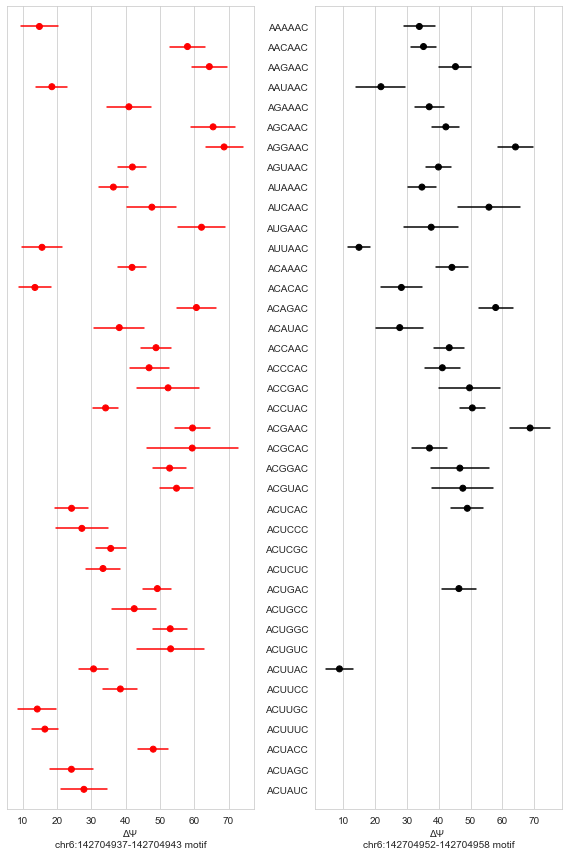

In [3]:
#HepG2_suppa_SE_df[(HepG2_suppa_SE_df.loc[:,'control'] == 'QKI_HepG2|42093_SE') &
#                 (HepG2_suppa_SE_df.loc[:,'unified_event_id'] == '21519;SE:21519:44-213:296-1003:+')]
sequence_design_info = pd.read_csv(base_dir + 'preprocessed_data/SRE_pool_sequences_dups_hg19.tsv', sep = '\t')
sequence_design_info['RBP_source'] = sequence_design_info.loc[:,'control'].str.split('|').str[0]
sequence_design_info = sequence_design_info.drop(['full_sequence', 'barcode'], axis = 1).drop_duplicates()

unified_event_id = '21519;SE:21519:44-213:296-1003:+'
rMATs_id = 'QKI_HepG2|42093_SE'
group_id = unified_event_id.split(';')[0]
substring = 'ACTAAC'
cell_line = 'HepG2'

this_sequence_row = sequence_design_info[(sequence_design_info.loc[:,'group_id'] == int(group_id)) &
                                          (sequence_design_info.loc[:,'control'] == rMATs_id)]
strand = this_sequence_row.loc[:,'strand'].iloc[0]

plot_df = HepG2_suppa_SE_df[(HepG2_suppa_SE_df.loc[:,'control'] == 'QKI_HepG2|42093_SE') &
                            (HepG2_suppa_SE_df.loc[:,'unified_event_id'] == '21519;SE:21519:44-213:296-1003:+') &
                           (HepG2_suppa_SE_df.loc[:,'position'] != '.')]
plot_df['position'] = plot_df.loc[:,'position'].astype(int)
buffer = 5
if strand == '+':
    relative_lower = plot_df.loc[:,'position'].min() - buffer - this_sequence_row['intron_lower'].iloc[0]
    relative_upper = plot_df.loc[:,'position'].max() + buffer + 1 - this_sequence_row['intron_lower'].iloc[0]
else:
    relative_lower = this_sequence_row['intron_upper'].iloc[0] - plot_df.loc[:,'position'].max() - buffer
    relative_upper = this_sequence_row['intron_upper'].iloc[0] - plot_df.loc[:,'position'].min() + buffer
    
ref_sequence = this_sequence_row.loc[:,'test_sequence'].iloc[0]
substring_inds = []; genomic_inds = []
for i in range(relative_lower, relative_upper-len(substring)):
    if ref_sequence[i:i+len(substring)] == substring:
        substring_inds.append(i)
        if strand == '+':
            genomic_inds.append(this_sequence_row['intron_lower'].iloc[0] + i + 1)
        else:
            genomic_inds.append(this_sequence_row['intron_upper'].iloc[0] - i)
genomic_inds = dict(zip(substring_inds,
                        [this_sequence_row['chromosome'].iloc[0] + ':' + str(x - 1) + '-' + str(x + len(substring)-1) for x in genomic_inds]))

def variant_substring(row, substring_locs, substring):
    var_seq = sequence_design_info[(sequence_design_info.loc[:,'control'] == rMATs_id) & 
                                   (sequence_design_info.loc[:,'group_id'] == int(row['group_id']))].loc[:,'test_sequence'].iloc[0]
    for substring_loc in substring_locs:
        var_sub = var_seq[substring_loc:substring_loc + len(substring)]
        if var_sub != substring:
            return [var_sub, substring_loc]
    
plot_df[['var_sub', 'motif_loc']] = plot_df.apply(variant_substring, axis = 1, substring_locs = substring_inds, substring = substring, result_type = 'expand')
dinucleotides = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
j=0; order = {}
for i in range(0, len(substring)-1):
    for dinulceotide in dinucleotides:
        var_sub = list(substring)
        var_sub[i:i+2] = list(dinulceotide)
        var_sub = ''.join(var_sub)
        order[var_sub] = j
        j+=1
plot_df['order'] = plot_df.loc[:,'var_sub'].map(order)
plot_df = plot_df.sort_values('order', ascending = False)
plot_df.loc[:,'var_sub'] =plot_df.loc[:,'var_sub'].str.replace('T', 'U')

def standard_dev_error_bars(row, cell_line, color_dict):
    ref_psis = smstats.weightstats.DescrStatsW(np.array([row[x] for x in [cell_line + '_ref_1', cell_line + '_ref_2', cell_line + '_ref_3']]))
    var_psis = smstats.weightstats.DescrStatsW(np.array([row[x] for x in [cell_line + '_var_1', cell_line + '_var_2', cell_line + '_var_3']]))
    #return [row['x'], row['x']] + list(smstats.weightstats.CompareMeans(var_psis, ref_psis).tconfint_diff(alpha = 0.1)) +[row['color']]
    STD = smstats.weightstats.CompareMeans(var_psis, ref_psis).std_meandiff_separatevar
    return [row['delta_psi']- STD, row['delta_psi'] + STD, row['order'],row['order'], color_dict[row['motif_loc']]]

plot_df['order'] = plot_df.loc[:,'order'].rank(method = 'dense', ascending = False)

color_dict = dict(zip(substring_inds, ['red', 'black']))
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 12))
ax_dict = dict(zip(substring_inds, [ax1, ax2]))
for motif_loc in substring_inds:
    these_points = plot_df[plot_df.loc[:,'motif_loc'] == motif_loc]
    this_ax = ax_dict[motif_loc]
    this_ax.scatter(these_points.loc[:,'delta_psi'], these_points.loc[:,'order'], c = these_points.loc[:,'motif_loc'].map(color_dict),
              label = genomic_inds[motif_loc])
    lines = list(these_points.apply(standard_dev_error_bars, cell_line = cell_line, axis = 1, color_dict = color_dict))
    for i in range(len(lines)):
        this_line = lines[i]
        this_ax.plot(this_line[0:2], this_line[2:4], c = this_line[4])
    this_ax.set_xlabel(u'\u0394\u03A8 \n' + genomic_inds[motif_loc] + ' motif')
    this_ax.set_ylim(0,40)
    this_ax.grid(False, axis = 'y')
    
plt.yticks(ticks = list(range(1, int(plot_df.loc[:,'order'].max()+1))), labels = plot_df.loc[:,'var_sub'].drop_duplicates())
ax1.yaxis.set_visible(False)
plt.tight_layout()
#plt.savefig(figure_out_dir + 'QKI_example_delta_psi.svg')


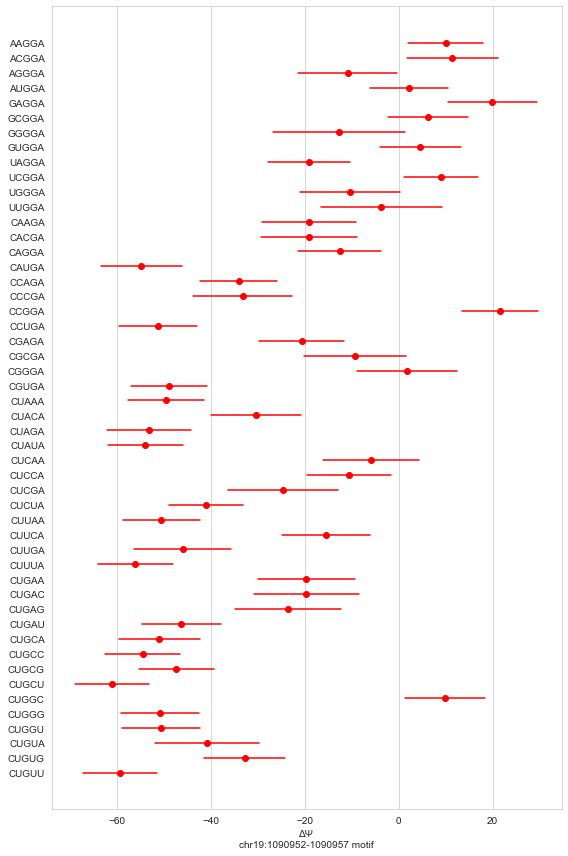

In [4]:
#K562_suppa_SE_df[(K562_suppa_SE_df.loc[:,'control'] == 'QKI_K562|42093_SE') &
#                 (K562_suppa_SE_df.loc[:,'unified_event_id'] == '21519;SE:21519:44-213:296-1003:+')]
sequence_design_info = pd.read_csv(base_dir + 'preprocessed_data/SRE_pool_sequences_dups_hg19.tsv', sep = '\t')
sequence_design_info['RBP_source'] = sequence_design_info.loc[:,'control'].str.split('|').str[0]
sequence_design_info = sequence_design_info.drop(['full_sequence', 'barcode'], axis = 1).drop_duplicates()

unified_event_id = '31842;SE:31842:44-215:295-1004:+'
rMATs_id = 'SRSF1_K562|45456_SE'
group_id = unified_event_id.split(';')[0]
substring = 'CTGGA'
cell_line = 'K562'

this_sequence_row = sequence_design_info[(sequence_design_info.loc[:,'group_id'] == int(group_id)) &
                                          (sequence_design_info.loc[:,'control'] == rMATs_id)]
strand = this_sequence_row.loc[:,'strand'].iloc[0]

plot_df = K562_suppa_SE_df[(K562_suppa_SE_df.loc[:,'control'] == rMATs_id) &
                            (K562_suppa_SE_df.loc[:,'unified_event_id'] == unified_event_id) &
                           (K562_suppa_SE_df.loc[:,'position'] != '.')]
plot_df['position'] = plot_df.loc[:,'position'].astype(int)
buffer = 5
if strand == '+':
    relative_lower = plot_df.loc[:,'position'].min() - buffer - this_sequence_row['intron_lower'].iloc[0]
    relative_upper = plot_df.loc[:,'position'].max() + buffer + 1 - this_sequence_row['intron_lower'].iloc[0]
else:
    relative_lower = this_sequence_row['intron_upper'].iloc[0] - plot_df.loc[:,'position'].max() - buffer
    relative_upper = this_sequence_row['intron_upper'].iloc[0] - plot_df.loc[:,'position'].min() + buffer
    
ref_sequence = this_sequence_row.loc[:,'test_sequence'].iloc[0]
substring_inds = []; genomic_inds = []
for i in range(relative_lower, relative_upper-len(substring)):
    if ref_sequence[i:i+len(substring)] == substring:
        substring_inds.append(i)
        if strand == '+':
            genomic_inds.append(this_sequence_row['intron_lower'].iloc[0] + i + 1)
        else:
            genomic_inds.append(this_sequence_row['intron_upper'].iloc[0] - i)
if strand == '+':
    genomic_inds = dict(zip(substring_inds,
                            [this_sequence_row['chromosome'].iloc[0] + ':' + str(x-1) + '-' + str(x + len(substring)-1) for x in genomic_inds]))
else:
        genomic_inds = dict(zip(substring_inds,
                            [this_sequence_row['chromosome'].iloc[0] + ':' + str(x - len(substring)) + '-' + str(x) for x in genomic_inds]))

def variant_substring(row, substring_locs, substring, ref_sequence):
    var_seq = sequence_design_info[(sequence_design_info.loc[:,'control'] == rMATs_id) & 
                                   (sequence_design_info.loc[:,'group_id'] == int(row['group_id']))].loc[:,'test_sequence'].iloc[0]
    for substring_loc in substring_locs:
        var_sub = var_seq[substring_loc:substring_loc + len(substring)]
        ham_dist = textdistance.hamming(var_seq, ref_sequence)
        if var_sub != substring:
            return [var_sub, substring_loc, ham_dist]
    return [np.nan, np.nan, np.nan]
    
plot_df[['var_sub', 'motif_loc', 'hamming_distance']] = plot_df.apply(variant_substring, axis = 1, substring_locs = substring_inds,
                                                  substring = substring, ref_sequence = ref_sequence, result_type = 'expand')
plot_df = plot_df.dropna()
dinucleotides = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
j=0; order = {}
for i in range(0, len(substring)-1):
    for dinulceotide in dinucleotides:
        var_sub = list(substring)
        var_sub[i:i+2] = list(dinulceotide)
        var_sub = ''.join(var_sub)
        order[var_sub] = j
        j+=1
plot_df['order'] = plot_df.loc[:,'var_sub'].map(order)
plot_df = plot_df.sort_values('order', ascending = False)
plot_df.loc[:,'var_sub'] = plot_df.loc[:,'var_sub'].str.replace('T', 'U')

def standard_dev_error_bars(row, cell_line, color_dict):
    ref_psis = smstats.weightstats.DescrStatsW(np.array([row[x] for x in [cell_line + '_ref_1', cell_line + '_ref_2', cell_line + '_ref_3']]))
    var_psis = smstats.weightstats.DescrStatsW(np.array([row[x] for x in [cell_line + '_var_1', cell_line + '_var_2', cell_line + '_var_3']]))
    #return [row['x'], row['x']] + list(smstats.weightstats.CompareMeans(var_psis, ref_psis).tconfint_diff(alpha = 0.1)) +[row['color']]
    STD = smstats.weightstats.CompareMeans(var_psis, ref_psis).std_meandiff_separatevar
    return [row['delta_psi']- STD, row['delta_psi'] + STD, row['order'],row['order'], 'red']

plot_df['order'] = plot_df.loc[:,'order'].rank(method = 'dense', ascending = False)
duplicated_subs = set(plot_df[plot_df.loc[:,'var_sub'].duplicated()].loc[:,'var_sub'])
filter_out_ind = plot_df[(plot_df.loc[:,'var_sub'].isin(duplicated_subs)) &
                        (plot_df.loc[:,'hamming_distance'] == 2)].index
plot_df = plot_df[plot_df.index.isin(filter_out_ind) == False]
color_dict = dict(zip(substring_inds, ['red', 'black']))
fig, ax = plt.subplots(1,1, figsize = (8, 12))

for motif_loc in substring_inds:
    these_points = plot_df[plot_df.loc[:,'motif_loc'] == motif_loc]
    this_ax = ax
    this_ax.scatter(these_points.loc[:,'delta_psi'], these_points.loc[:,'order'], c = 'red',
              label = genomic_inds[motif_loc])
    lines = list(these_points.apply(standard_dev_error_bars, cell_line = cell_line, axis = 1, color_dict = color_dict))
    for i in range(len(lines)):
        this_line = lines[i]
        this_ax.plot(this_line[0:2], this_line[2:4], c = this_line[4])
    this_ax.set_xlabel(u'\u0394\u03A8 \n' + genomic_inds[motif_loc] + ' motif')
    #this_ax.set_ylim(0,40)
plt.yticks(ticks = list(range(1, int(plot_df.loc[:,'order'].max()+1))), labels = plot_df.loc[:,'var_sub'].drop_duplicates())
ax.grid(False, axis = 'y')

plt.tight_layout()
#plt.savefig(figure_out_dir + 'SRSF1_example_delta_psi.svg')


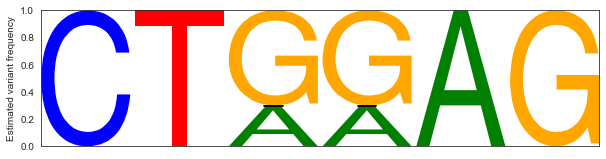

In [5]:
samples = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', '2-13', '2-15', '3-6']
genotypes = ['A', 'A', 'A', 'B', 'B', 'B', 'SRSF1_2', 'SRSF1_2', 'SRSF1_3']
#variant allele frequencies estimated by Tracy and Sanger sequencing traces
tracy_VAF = [0.62, 0.59, 0.51, 0.28, 0.24, 0.31, 0.36, 0.36, 0.3]
dates = ['03122020', '07292020', '07292020', '03122020', '03122020', '07292020', '07292020', '07292020', '07212020'] #based on best Sanger sequence quality
reference = ['ACTAAC', 'ACTAAC', 'ACTAAC', 'ACTAAC', 'ACTAAC', 'ACTAAC', 'CTCCAG', 'CTCCAG', 'CTCCAG']
variant = ['ACCAAC', 'ACCAAC', 'ACCAAC', 'ACTAAT', 'ACTAAT', 'ACTAAT', 'TTTTAG', 'TTTTAG', 'CTTTAG']
strand = ['+'] *6 + ['-']*3

variant_df = pd.DataFrame({'sample': samples, 'genotype': genotypes, 'VAF': tracy_VAF,
                           'date': dates, 'reference': reference, 'variant':variant, 'strand': strand})
def reverse_complement(seq):
    complement = dict(zip(['A','C','G','T','U'], ['T','G','C','A','A']))
    return ''.join([complement[nuc] for nuc in seq][::-1])

def variant_plot(variant_df, genotype, ref_only = False):
    this_df = variant_df[variant_df.loc[:,'genotype'] == genotype]
    ref_seq = list(set(this_df.loc[:,'reference']))[0]
    var_seq = list(set(this_df.loc[:,'variant']))[0]
    if list(this_df.loc[:,'strand'].str.contains('-'))[0]:
        ref_seq = reverse_complement(ref_seq)
        var_seq = reverse_complement(var_seq)
    if ref_only:
        logo_matrix = logomaker.sequence_to_matrix(ref_seq)
    else:
        average_VAF = this_df.loc[:,'VAF'].mean()
        logo_alphabet = ['A', 'C', 'G', 'T']
        this_matrix = {}; var_locs = []
        for i in range(len(ref_seq)):
            this_matrix[i] = dict(zip(logo_alphabet, [0,0,0,0]))
            if ref_seq[i] == var_seq[i]:
                this_matrix[i][ref_seq[i]] = 1
            else:
                this_matrix[i][ref_seq[i]] = 1 - average_VAF
                this_matrix[i][var_seq[i]] = average_VAF
                var_locs.append(i)
        logo_matrix = pd.DataFrame(this_matrix).transpose()
    logo = logomaker.Logo(logo_matrix, color_scheme = 'classic', font_name = 'Helvetica Neue')
    STD = np.std(this_df.loc[:,'VAF'])
    if ref_only == False:
        for loc in var_locs:
            if average_VAF >= 0.5:
                logo.ax.plot([loc, loc], [(1 - average_VAF) - STD, (1 - average_VAF) + STD], color = 'black', zorder = 3)
                logo.ax.plot([loc- 0.1, loc+0.1], [(1 - average_VAF) - STD, (1 - average_VAF) - STD], color = 'black', zorder = 3)
                logo.ax.plot([loc- 0.1, loc+0.1], [(1 - average_VAF) + STD, (1 - average_VAF) + STD], color = 'black', zorder = 3)
            else:
                logo.ax.plot([loc, loc], [average_VAF - STD, average_VAF + STD], color = 'black', zorder = 3)
                logo.ax.plot([loc- 0.1, loc+0.1], [average_VAF - STD, average_VAF - STD], color = 'black', zorder = 3)
                logo.ax.plot([loc- 0.1, loc+0.1], [average_VAF + STD, average_VAF + STD], color = 'black', zorder = 3)
    logo.ax.xaxis.set_visible(False); logo.ax.set_ylabel('Estimated variant frequency')
    return logo
    
sns.set_style("white")

#run through all of the samples seperately to get all of the logos in Figure 7
logo = variant_plot(variant_df, 'SRSF1_3', ref_only = False)
#plt.savefig(figure_out_dir + 'SRSF1_K562_45456_SE_WT_estimated_AF.svg')
#plt.savefig(figure_out_dir + 'SRSF1_K562_45456_SE_clone_2_estimated_AF.svg')
#plt.savefig(figure_out_dir + 'SRSF1_K562_45456_SE_clone_3_estimated_AF.svg')

#logo = variant_plot(variant_df, 'B', ref_only = False)
#plt.savefig(figure_out_dir + 'QKI_HepG2_42093_SE_WT_estimated_AF.svg')
#plt.savefig(figure_out_dir + 'QKI_HepG2_42093_SE_A_estimated_AF.svg')
#plt.savefig(figure_out_dir + 'QKI_HepG2_42093_SE_B_estimated_AF.svg')

1.4129926304799154e-05
0.025289527428027914


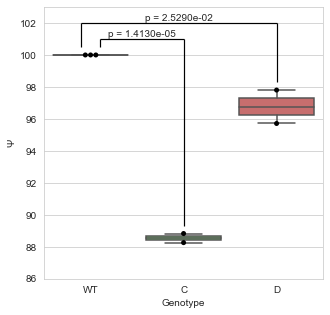

In [6]:
sns.set_style("whitegrid")
def annotate_pvalue(x1, x2, y1, y2, pvalue, ax, mini_buffer = 1, buffer = 2):
    new_y_level = max([y1, y2]) + buffer
    lines = [[(x1,y1+mini_buffer), (x1,new_y_level)], [(x1,new_y_level), (x2,new_y_level)], [(x2, new_y_level), (x2, y2 + mini_buffer)]]
    lc = mc.LineCollection(lines, color = 'black', linewidths=1.2)
    ax.add_collection(lc)
    ax.text((x1 + x2)/2, new_y_level, s = 'p = ' + '{:0.4e}'.format(pvalue), horizontalalignment = 'center', verticalalignment = 'bottom')

gel_df = pd.read_csv(base_dir + 'preprocessed_data/SRSF1_gel_splicing_quantifications.csv')
gel_df = gel_df.transpose()

new_header = gel_df.iloc[0]
gel_df = gel_df[1:]
gel_df.columns = new_header
numeric_colums = ['PSI', 'Upper Band intensity', 'Lower Band intensity']
for col in numeric_colums:
    gel_df[col] = gel_df.loc[:,col].astype(float)

fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(x = 'Genotype', y='PSI', data = gel_df, ax = ax)
sns.swarmplot(x = 'Genotype', y='PSI', data = gel_df, ax = ax, color = 'black')

WT_C_p = stats.ttest_ind(gel_df[gel_df.loc[:,'Genotype'] == 'WT'].loc[:,'PSI'],
                     gel_df[gel_df.loc[:,'Genotype'] == 'C'].loc[:,'PSI'])[1]
WT_D_p = stats.ttest_ind(gel_df[gel_df.loc[:,'Genotype'] == 'WT'].loc[:,'PSI'],
                     gel_df[gel_df.loc[:,'Genotype'] == 'D'].loc[:,'PSI'])[1]
annotate_pvalue(0.1,1,100, 88.833, WT_C_p, ax, mini_buffer = 0.5, buffer =1)
annotate_pvalue(-0.1,2,100, 97.805, WT_D_p, ax, mini_buffer = 0.5, buffer = 2)

plt.ylim(86,103)
ax.set_ylabel(u'\u03A8')

#plt.savefig(figure_out_dir + 'Figure_SRSF1_K562_45456_base_edit_quant.svg')
print(WT_C_p)
print(WT_D_p)

2.0367380551837106e-05
0.003944066711695346


Text(0, 0.5, 'Ψ')

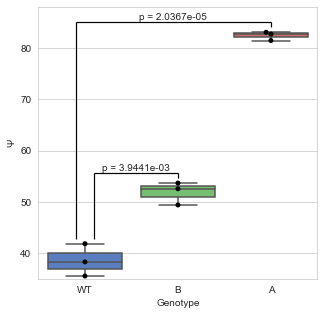

In [7]:
gel_df = pd.read_csv(base_dir + 'preprocessed_data/QKI_gel_splicing_quantifications.csv')
gel_df = gel_df.transpose()

new_header = gel_df.iloc[0]
gel_df = gel_df[1:]
gel_df.columns = new_header 
numeric_colums = ['PSI', 'Upper Band intensity', 'Lower Band intensity']
for col in numeric_colums:
    gel_df[col] = gel_df.loc[:,col].astype(float)

fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(x = 'Genotype', y='PSI', data = gel_df, ax = ax)
sns.swarmplot(x = 'Genotype', y='PSI', data = gel_df, ax = ax, color = 'black')

WT_A_pval = stats.ttest_ind(gel_df[gel_df.loc[:,'Genotype'] == 'WT'].loc[:,'PSI'],
                     gel_df[gel_df.loc[:,'Genotype'] == 'A'].loc[:,'PSI'])[1]
WT_B_pval = stats.ttest_ind(gel_df[gel_df.loc[:,'Genotype'] == 'WT'].loc[:,'PSI'],
                     gel_df[gel_df.loc[:,'Genotype'] == 'B'].loc[:,'PSI'])[1]

annotate_pvalue(0.1,1, 41.846,53.673, WT_B_pval, ax)
annotate_pvalue(-0.1,2, 41.846,83.074, WT_A_pval, ax)

plt.ylim(35,88)
print(WT_A_pval)
print(WT_B_pval)

ax.set_ylabel(u'\u03A8')

#plt.savefig(figure_out_dir + 'QKI_HepG2_42093_base_edit_quant.svg')


In [8]:
mCross_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'mCross_scores.tsv', sep = '\t')
mCross_df['motif_source'] = 'mCross'

RBNS_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'RBPamp_scores.tsv', sep = '\t')
RBNS_df['motif_source'] = 'RBPamp'

motif_df = pd.concat([mCross_df, RBNS_df])
mCross_df = None; RBNS_df = None

def format_plot_df(suppa_df_SE):
    plot_df = suppa_df_SE.loc[:,('group_id', 'reference_id', 'unified_event_id', 'delta_psi', 'var_psi', 'RBP_source')]
    plot_df = motif_df.merge(plot_df, on = ['group_id', 'reference_id', 'unified_event_id'], how = 'left').dropna()

    plot_df['upstream_ratio'] = np.log10(plot_df.loc[:,'upstream_var']/ plot_df.loc[:,'upstream_ref'])
    plot_df['downstream_ratio'] = np.log10(plot_df.loc[:,'downstream_var'] / plot_df.loc[:,'downstream_ref'])
    plot_df['exon_ratio'] = np.log10(plot_df.loc[:,'exon_var'] / plot_df.loc[:,'exon_ref'])
    return plot_df

HepG2_plot_df = format_plot_df(HepG2_suppa_SE_df[(HepG2_suppa_SE_df.loc[:,'3SS_status'] == 'Same') & 
                                                (HepG2_suppa_SE_df.loc[:,'5SS_status'] == 'Same')])
K562_plot_df = format_plot_df(K562_suppa_SE_df[(K562_suppa_SE_df.loc[:,'3SS_status'] == 'Same') & 
                                                (K562_suppa_SE_df.loc[:,'5SS_status'] == 'Same')])
motif_df = None

In [9]:
#the code in this cell is correlating delta psi with change in motif strength between variant and reference accross SREs

def handle_multitest_na(df, region):
    df[region + '_corrected_pval'] = np.nan
    mask = np.isfinite(df.loc[:, region + '_pval'])
    df[region + '_corrected_pval'][mask] = smstats.multitest.multipletests(df.loc[:,region + '_pval'][mask], method = 'fdr_bh')[1]
    return df

def filter_motif(row, mCross_filter, RBPamp_filter, n_rows = 10000):
    for region in ['upstream', 'exon', 'downstream']:
        if row['motif_source'] == 'mCross':
            if row[region + '_ref'] < mCross_filter and row[region + '_var'] < mCross_filter:
                row[region + '_ratio'] = np.nan
        elif row['motif_source'] == 'RBPamp':
            if row[region + '_ref'] < RBPamp_filter and row[region + '_var'] < RBPamp_filter:
                row[region + '_ratio'] = np.nan
    progress_bar(row.name, n_rows)
    return row

def grouped_spearman(x, region):
    try:
        return pd.Series([x['unified_event_id']] + list(stats.spearmanr(x['delta_psi'], x[region + '_ratio'])) +
                                                        [len(x['delta_psi']), x[region + '_ratio'].std(), x['delta_psi'].std()])
    except ValueError:
        return pd.Series([x['unified_event_id'], np.nan, np.nan, len(x['delta_psi']), x[region + '_ratio'].std(), x['delta_psi'].std()])

def motif_corr_plot(plot_df, cell_line, mCross_filter = -1, RBPamp_filter = -1, v = None):
    n_rows = plot_df.shape[0]
    if mCross_filter != -1 or RBPamp_filter !=-1:
        print('filtering...')
        for region in ['upstream', 'exon', 'downstream']:
            mask_ind = (plot_df.loc[:,'motif_source'] == 'mCross') & ((plot_df.loc[:,region + '_ref'] < mCross_filter) | (plot_df.loc[:,region + '_var'] < mCross_filter))
            plot_df[region + '_ratio'][mask_ind] = np.nan
            mask_ind = (plot_df.loc[:,'motif_source'] == 'RBPamp') & ((plot_df.loc[:,region + '_ref'] < RBPamp_filter) | (plot_df.loc[:,region + '_var'] < RBPamp_filter))
            plot_df[region + '_ratio'][mask_ind] = np.nan
        print('done filtering')
    overall_corr_df = plot_df.loc[:,('motif_id', 'upstream_ratio', 'exon_ratio', 'downstream_ratio', 'delta_psi', 'motif_source', 'unified_event_id', 'group_id')]

    corr_dict = {}
    all_motifs = list(set(overall_corr_df.loc[:,'motif_id'])); motif_sources = []

    grouped_motifs = set()
    for motif in all_motifs:
        if '.' not in motif:
            grouped_motifs.add(motif)
        else:
            grouped_motifs.add('.'.join(motif.split('.')[0:2]))
    grouped_motifs = list(grouped_motifs)
    overall_corr_df2 = pd.DataFrame()
    motif_sources = {}
    for motif in grouped_motifs:
        if '.' in motif:
            this_df = overall_corr_df[overall_corr_df.loc[:,'motif_id'].str.contains(motif)]
            this_df = this_df.replace(np.inf, 1).replace(-np.inf, -1)
            this_motif_source = 'mCross'
            this_df = this_df.groupby(['unified_event_id', 'group_id']).mean().reset_index()
        else:
            this_df = overall_corr_df[overall_corr_df.loc[:,'motif_id'] == motif]
            this_motif_source = 'RBPamp'
        motif_sources[motif] = this_motif_source
        for region in ['upstream', 'downstream', 'exon']:
            region_df = this_df.loc[:,(region + '_ratio', 'delta_psi', 'unified_event_id')].dropna()
            region_df = region_df[region_df.loc[:,region + '_ratio'] != 0]
            region_corrs = pd.DataFrame(region_df.groupby(['unified_event_id']).apply(grouped_spearman, region = region)).dropna()
            if region_corrs.shape[0] != 0:
                region_corrs.columns = ['unified_event_id', 'correlation', 'pvalue', 'observations', 'ratio_std', 'delta_psi_std']
                region_corrs['BH_pvalue'] = smstats.multitest.multipletests(region_corrs.loc[:,'pvalue'], method = 'fdr_bh')[1]
                region_corrs['region'] = region
                region_corrs['motif'] = motif
                overall_corr_df2 = pd.concat([overall_corr_df2, region_corrs])
    overall_corr_df2['motif_source'] = overall_corr_df2.loc[:,'motif'].map(motif_sources)
    if cell_line == 'HepG2':
        overall_corr_df2 =overall_corr_df2[(overall_corr_df2.loc[:,'motif_source'] == 'RBPamp') | overall_corr_df2.loc[:,'motif'].str.contains('HepG2')]
        overall_corr_df2 = overall_corr_df2[overall_corr_df2.loc[:,'motif'].isin(['SRSF9', 'KHSRP']) == False]
    elif cell_line == 'K562':
        overall_corr_df2 =overall_corr_df2[(overall_corr_df2.loc[:,'motif_source'] == 'RBPamp') | overall_corr_df2.loc[:,'motif'].str.contains('K562')]
    overall_corr_df2['unified_event_id'] = list(overall_corr_df2.index)
    overall_corr_df2 = overall_corr_df2.reset_index(drop=True)
    return overall_corr_df2

HepG2_corr_filt_df = motif_corr_plot(HepG2_plot_df, 'HepG2')
K562_corr_filt_df = motif_corr_plot(K562_plot_df, 'K562')

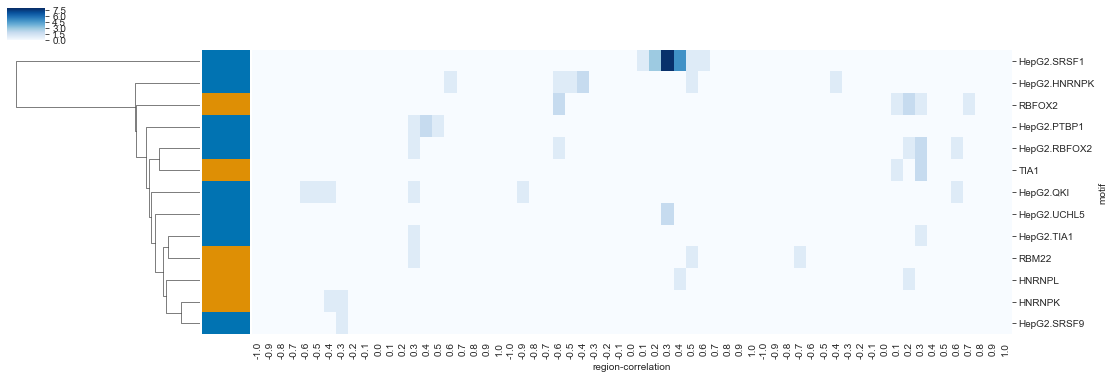

In [10]:
def corr_heatmap(df, width =18, height =6):
    df = df[(df.loc[:,'BH_pvalue'] != 0) &
                             (df.loc[:,'BH_pvalue']<=0.05)]
    bins = []; motifs = []; regions = []; counts = []
    for i in range(-10,11):
        floor = i/10
        ceiling = (i+1)/10
        for motif in set(df.loc[:,'motif']):
            for region in ['exon', 'upstream', 'downstream']:
                this_df = df[(df.loc[:,'motif'] == motif) & (df.loc[:,'region'] == region) &
                               (df.loc[:,'correlation'] > floor) & (df.loc[:,'correlation'] < ceiling)]
                bins.append(floor); motifs.append(motif); regions.append(region)
                counts.append(this_df.shape[0])
    heatmap_df = pd.DataFrame({'correlation': bins,'region':regions, 'count': counts, 'motif':motifs})
    heatmap_df = heatmap_df.pivot(index = ['region', 'correlation'], values = 'count', columns = 'motif')
    heatmap_df = heatmap_df.loc[['upstream', 'exon', 'downstream']]
    motif_names = list(heatmap_df.columns)
    motifs = []
    for motif in motif_names:
        if 'HepG2' in motif or 'K562' in motif:
            motifs.append(sns.color_palette('colorblind', 2)[0])
        else:
            motifs.append(sns.color_palette('colorblind', 2)[1])
    motifs = pd.Series(motifs, index = motif_names)
    g = sns.clustermap(heatmap_df.transpose() ,col_cluster = False, cmap = "Blues", figsize=(width, height), row_colors = motifs)
    g.ax_heatmap.set_xticklabels([x[1] for x in heatmap_df.index])
    
corr_heatmap(HepG2_corr_filt_df)

#plt.savefig(figure_out_dir + 'Figure_7A_HepG2_motif_delta_psi_correlation_v3.svg', bbox_inches = "tight")
#plt.savefig(figure_out_dir + 'Figure_7A_HepG2_motif_delta_psi_correlation_v3.png', bbox_inches = "tight")

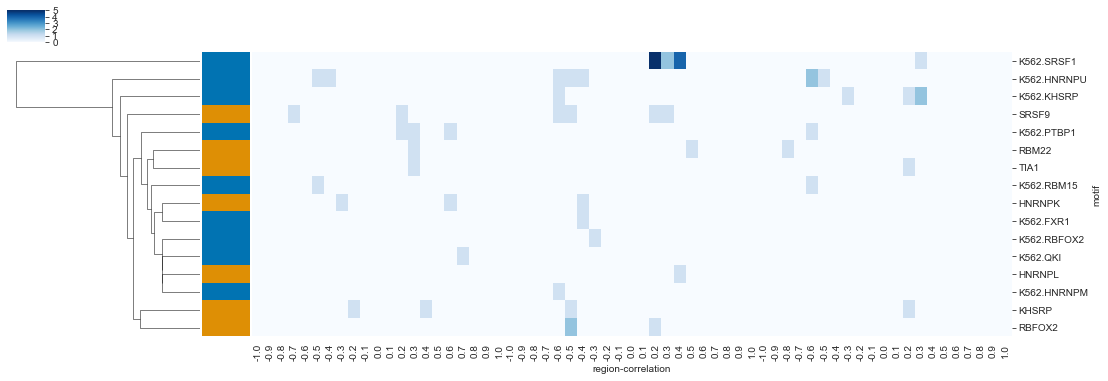

In [11]:
corr_heatmap(K562_corr_filt_df)
#plt.savefig(figure_out_dir + 'Figure_7B_K562_motif_delta_psi_correlation_v3.svg', bbox_inches = "tight")
#plt.savefig(figure_out_dir + 'Figure_7B_K562_motif_delta_psi_correlation_v3.png', bbox_inches = "tight")

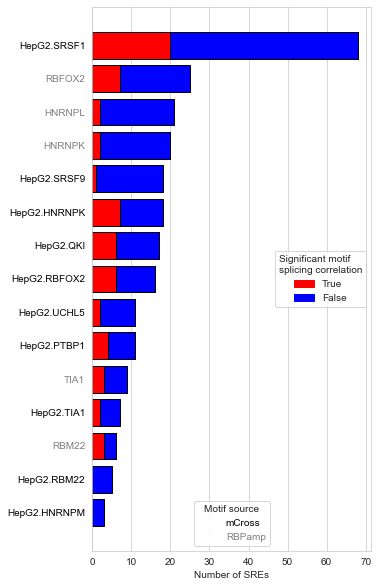

In [12]:
HepG2_sig = HepG2_corr_filt_df[HepG2_corr_filt_df.loc[:,'BH_pvalue'] <= 0.05].groupby(['motif', 'motif_source']).count().loc[:,'unified_event_id']
HepG2_all = HepG2_corr_filt_df.groupby(['motif', 'motif_source']).count().loc[:,'unified_event_id']
K562_sig = K562_corr_filt_df[K562_corr_filt_df.loc[:,'BH_pvalue'] <= 0.05].groupby(['motif', 'motif_source']).count().loc[:,'unified_event_id']
K562_all = K562_corr_filt_df.groupby(['motif', 'motif_source']).count().loc[:,'unified_event_id']

corr_summary_df = pd.concat([HepG2_sig, HepG2_all], axis =1).reset_index()
corr_summary_df.columns = ['motif', 'motif_source', 'sig', 'all']
corr_summary_df = corr_summary_df.sort_values('all', ascending = True).fillna(0).reset_index()

def NS_hist(summary_df):
    fig, ax = plt.subplots(1,1, figsize = (5,10))

    ax.barh(summary_df.loc[:,'motif'], width = summary_df.loc[:,'sig'], color = 'red', edgecolor = 'black')
    ax.barh(summary_df.loc[:,'motif'], width = summary_df.loc[:,'all'] - summary_df.loc[:,'sig'], 
            left = summary_df.loc[:,'sig'], color = 'blue', edgecolor = 'black')

    color_dict = dict(zip(['mCross', 'RBPamp'], ['black', 'gray']))
    for i in range(0, summary_df.shape[0]):
        row = summary_df.iloc[i]
        ax.get_yticklabels()[i].set_color(color_dict[row['motif_source']])

    plt.xlabel('Number of SREs')
    ax.grid(False, axis = 'y')
    
    legend_TN = [patches.Patch(color = 'red', label = 'True'), patches.Patch(color = 'blue', label = 'False')]
    legendA = ax.legend(title = 'Significant motif\nsplicing correlation', loc='right', handles=legend_TN,frameon=True)
    ax = plt.gca().add_artist(legendA)

    legend_TN = [patches.Patch(color = 'white', label = 'mCross'), patches.Patch(color = 'white', label = 'RBPamp')]
    plt.legend(title = 'Motif source', loc='lower center', handles = legend_TN, frameon=True, labels = ['mCross', 'RBPamp'], labelcolor = ['black', 'gray'])

    
NS_hist(corr_summary_df)

#plt.savefig(figure_out_dir + 'Supplemental_Figure_5A_HepG2_motif_delta_psi_correlations_bar.svg')

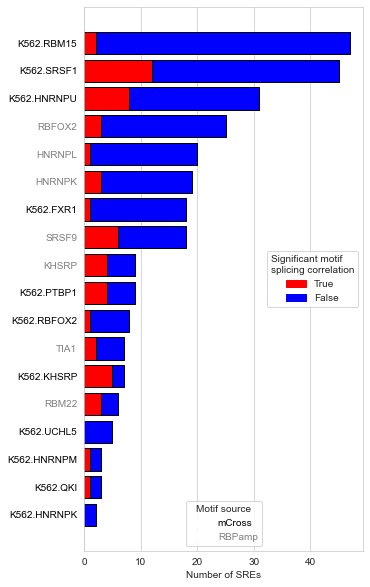

In [13]:
K562_sig = K562_corr_filt_df[K562_corr_filt_df.loc[:,'BH_pvalue'] <= 0.05].groupby(['motif', 'motif_source']).count().loc[:,'unified_event_id']
K562_all = K562_corr_filt_df.groupby(['motif', 'motif_source']).count().loc[:,'unified_event_id']

corr_summary_df = pd.concat([K562_sig, K562_all], axis =1).reset_index()
corr_summary_df.columns = ['motif', 'motif_source', 'sig', 'all']
corr_summary_df = corr_summary_df.sort_values('all', ascending = True).fillna(0).reset_index()
NS_hist(corr_summary_df)
#plt.savefig(figure_out_dir + 'Supplemental_Figure_5B_K562_motif_delta_psi_correlations_bar.svg')

p 1.5394618651904512e-07
CLES 0.6561524787675291
n_sig 122
n_non_sig 415


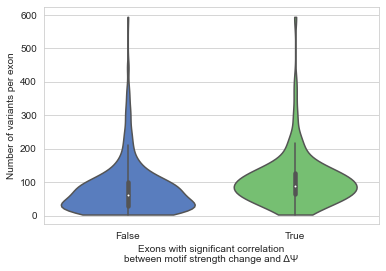

In [14]:
combo_corr_df = pd.concat([HepG2_corr_filt_df, K562_corr_filt_df], axis = 0) 
combo_corr_df['sig'] = combo_corr_df.loc[:,'BH_pvalue'] <= 0.05

sns.violinplot(x = 'sig', y = 'observations', data = combo_corr_df, cut = 0)
plt.ylabel('Number of variants per exon')
plt.xlabel(u'Exons with significant correlation\nbetween motif strength change and \u0394\u03A8')

mwu = stats.mannwhitneyu(combo_corr_df[combo_corr_df.loc[:,'sig'] == True].loc[:,'observations'],
                         combo_corr_df[combo_corr_df.loc[:,'sig'] == False].loc[:,'observations'], alternative = 'two-sided')
n_sig = len(combo_corr_df[combo_corr_df.loc[:,'sig'] == True].loc[:,'observations'])
n_non_sig = len(combo_corr_df[combo_corr_df.loc[:,'sig'] == False].loc[:,'observations'])
print('p', mwu[1])
print('CLES', mwu[0]/(n_sig * n_non_sig))

print('n_sig', n_sig)
print('n_non_sig',n_non_sig)
#plt.savefig(figure_out_dir + 'Supplemental_Figure_5C_motif_delta_psi_violin_variants.svg')

p 0.00020245867331872524
CLES 0.6105866087300019
n_sig 122
n_non_sig 415


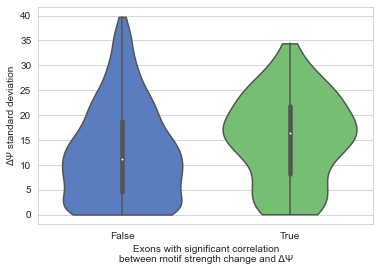

In [15]:
sns.violinplot(x = 'sig', y = 'delta_psi_std', data = combo_corr_df, cut = 0)

plt.ylabel(u'\u0394\u03A8 standard deviation')
plt.xlabel(u'Exons with significant correlation\nbetween motif strength change and \u0394\u03A8')

mwu = stats.mannwhitneyu(combo_corr_df[combo_corr_df.loc[:,'sig'] == True].loc[:,'delta_psi_std'],
                         combo_corr_df[combo_corr_df.loc[:,'sig'] == False].loc[:,'delta_psi_std'], alternative = 'two-sided')
n_sig = len(combo_corr_df[combo_corr_df.loc[:,'sig'] == True].loc[:,'delta_psi_std'])
n_non_sig = len(combo_corr_df[combo_corr_df.loc[:,'sig'] == False].loc[:,'delta_psi_std'])
print('p', mwu[1])
print('CLES', mwu[0]/(n_sig * n_non_sig))

print('n_sig', n_sig)
print('n_non_sig',n_non_sig)

#plt.savefig(figure_out_dir + 'Supplemental_Figure_5D_motif_delta_psi_violin_DP_std.svg')